# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint

from IPython.display import Image
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')

In [7]:
## Load the data into a DataFrame
df = pd.read_csv("Iowa_Liquor_Sales.csv")

df.head()

IOError: File Iowa_Liquor_Sales.csv does not exist

In [ ]:
df.info()

### Data Munging

In [ ]:
df['Date'] = df['Date'].apply(pd.to_datetime)

In [ ]:
# Function to convert money columns from string to float

def conv_money(x):
    x = x.split('.')
    return (float(x[0][1:]) + (float(x[1]) / 100))

In [ ]:
# Converting columns with money value to float

df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]] = \
df[['State Bottle Cost', 'State Bottle Retail', "Sale (Dollars)"]].applymap(conv_money)

In [ ]:
df['Item Description'] = df['Item Description'].apply(lambda x: x.strip())

In [ ]:
df.info()

## Cleaning Zipcodes

In [ ]:
## Checking to see if all zipcodes have length of 5

df[df['Zip Code'].apply(lambda x: len(str(x)) != 5)]

In [ ]:
# Since all has 5, change all to int types

df[df['Zip Code'].apply(lambda x: int(x))]

In [ ]:
# Even all is length 5, 1 entry was '712-2'
# Googled this, turned out to be area code, change to 51529

df[df['Zip Code'].apply(lambda x: x == '712-2')]

In [ ]:
# Changed erroneous zipcode

df.loc[df['Zip Code'] == '712-2', 'Zip Code'] = '51529'


In [ ]:
# Changed zipcodes to int type

df['Zip Code'] = df['Zip Code'].apply(lambda x: int(x))

In [ ]:
Image(filename='wrong_zip_des_moines.png')

In [ ]:
# Correct Zip Code for Des Moines, Burlington

df.loc[df['Zip Code'] == 56201, 'Zip Code'] = 52601

## Cleaning City Values

In [ ]:
list(df['City'].unique())

In [ ]:
# There are some 'City' entries which are in lower case while the majority is in Upper Case. 
# To prevent double counting, all "City" entries are changed to upper case

df['City'] = df['City'].apply(lambda x: x.upper())

## Cleaning NaN County entries

In [ ]:
# Create a new dataframe for rows with NaNs in any cells

df_nan = df[pd.isnull(df).any(axis = 1)]

In [ ]:
df_nan.head()

In [ ]:
# Printing columns that contain "NaN" and count the number of NaN entries per column

tbc_list = []

for col in df.columns:
    x = sum(pd.isnull(df[col]))
    if x != 0:
        tbc_list.append(col)
        print col, x

In [ ]:
# Some counties and county numbers are not filled.
# Since "City" column does not contain NaN and Cities are a subset of counties,
# we try to see if there are similar cities with non-empty county values which we can then copy to the NaN county cells


# Create a set of Cities with NaN for county or county Number

city_nan_list = list(df_nan['City'].unique())

city_nan_list

In [ ]:
# Creating a dictionary with "City" as key and collecting all possible corresponding "County" and "County Name"
# as values of the dictionary

nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County'] if x > 0} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number'] if x > 0}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

In [ ]:
## Replacing NaN county cells using corresponding city value as key

for cty in nan_cty_dict:
    try:
        df.loc[df['City'] == cty, 'County'] = nan_cty_dict[cty][0][0]
        df.loc[df['City'] == cty, "County Number"] = nan_cty_dict[cty][1][0]
    except:
        pass

In [ ]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df[['County','County Number']]).any(axis = 1)]

In [ ]:
# Collect cities with NaN values
city_nan_list = list(df_nan['City'].unique())

city_nan_list

In [ ]:
nan_cty_dict = {}

for j in city_nan_list:
    c_set = {x for x in df[df['City']==j]['County']} # x > 0 to skip NaN values
    num_set = {x for x in df[df['City']==j]['County Number']}
    nan_cty_dict[j] = [list(c_set), list(num_set)]

nan_cty_dict

In [ ]:
# Updating counties by hand

df.loc[df['City'] == 'TABOR', 'County'] = 'Fremont'
df.loc[df['City'] == 'RUNNELLS', 'County'] = 'Polk'
df.loc[df['City'] == 'SEYMOUR', 'County'] = 'Wayne'

In [ ]:
# Recreate a new df to check remaining NaN row
df_nan = df[pd.isnull(df['County'])]

In [ ]:
len(df_nan)

#### Comments:

Remaining 12 rows with empty counties were filled manually. Without a reference of how county numbers were developed, we left the empty county numbers empty. Analyses based on counties will be performed on 'County' instead of 'County Number'.

# ---------------------------------------------------------------

## Cleaning Empty Category Name using Item Decription

In [ ]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

In [ ]:
# Create a list of "Item Description" with NaN in rows
item_nan_list = list(df_nan['Item Description'].unique())

item_nan_list

In [ ]:
item_dict = {}

for j in item_nan_list:
    c_set = {x for x in df[df['Item Description']==j]['Category Name'] if x > 0}
    item_dict[j] = list(c_set)

item_dict

In [ ]:
for drink in item_dict:
    try:
        df.loc[df['Item Description'] == drink, 'Category Name'] = item_dict[drink][0]
    except:
        pass

In [ ]:
df_nan = df[pd.isnull(df['Category Name'])]
print len(df_nan)
df_nan

In [ ]:
df_nan['Item Description'].unique()

In [ ]:
package = ['Jack Daniels TN Honey & Jack Daniels TN Fire 750mls w/2Gls', 'Bombay Sapphire w/Glass',\
           'Evan Williams Egg Nog', 'Pinnacle Candy Cane Trial Pack', 'Wild Turkey American Honey Shot Tap',\
           'Knob Creek w/ Crystal Decanter']

for i in package:
    df.loc[df['Item Description'] == i,'Category Name'] = 'DECANTERS & SPECIALTY PACKAGES'

In [ ]:
df.loc[df['Item Description'] == 'Woodford Reserve MC 1838 White Corn',\
       'Category Name'] = 'CORN WHISKIES'

df.loc[df['Item Description'] == 'Hudson New York Corn',\
       'Category Name'] = 'CORN WHISKIES'

In [ ]:
lique = ['Rothman & Winter Orchard Peach', 'Giffard Creme de Pamplemousse Rose Pink Grapefruit Liqueur',\
        'Pearl Caramel', 'Tiramisu Italian Liqueur', 'The Bitter Truth Apricot Liqueur',\
       'The Bitter Truth Violet Liqueur', 'Kahlua Mocha', "Dr. McGillicuddy's Mentholmint", 'Alize Blue',\
         'The Kings Ginger', 'Courvoisier Gold', 'Grand Marnier Cuvee 1880 HA', 'Cocoyac Excellence'\
        ]

for i in lique:
    df.loc[df['Item Description'] == i,'Category Name'] ='MISC. IMPORTED CORDIALS & LIQUEURS'

In [ ]:
scotch = ['Westland American Single Malt',
       'Westland Peated Single Malt', 'Westland Sherry Wood Single Malt'\
          'Glenfiddich 1963 Replica HA']

for s in scotch:
    df.loc[df['Item Description'] == s, 'Category Name'] ='SINGLE MALT SCOTCH'

In [ ]:
df.loc[df['Item Description'] == 'Parkers Heritage Collection Malt Whiskey HA',\
       'Category Name'] = "STRAIGHT BOURBON WHISKIES"

df.loc[df['Item Description'] == 'Chivas Regal 18YR Tin HA',\
       'Category Name'] = 'BLENDED WHISKIES'


In [ ]:
vod = ['High Stick Vodka', 'Ciroc Ten HA', 'Ultimat Vodka', 'Karlssons Gold Vodka']

for i in vod:
    df.loc[df['Item Description'] == i,'Category Name'] = 'IMPORTED VODKA'

df.loc[df['Item Description'] == 'Absolut Black 100', 'Category Name'] = '100 PROOF VODKA'

fvod = ['Van Gogh Rich Dark Chocolate Vodka',\
        'Absolut w/Ginger Beer',\
       'Van Gogh Chocolate Vodka',\
       'Svedka Strawberry Lemonade Vodka',\
       'Van Gogh Coconut', 'Alize Gold']

for f in fvod:
    df.loc[df['Item Description'] == f, 'Category Name'] = 'VODKA FLAVORED'
    
    
df.loc[df['Item Description'] == 'Twenty Grand Gold',\
       'Category Name'] = 'VODKA 80 PROOF'

In [ ]:
teq = ['Del Maguey San Luis Del Rio', "Hussong's Reposado Tequila 100% Agave"]

for t in teq:
    df.loc[df['Item Description'] == t, 'Category Name'] = 'TEQUILA'

In [ ]:
df.loc[df['Item Description'] == 'Kraken Black Mini', 'Category Name'] = 'SPICED RUM'

df.loc[df['Item Description'] == 'The Bitter Truth Pimento Dram', 'Category Name'] = 'JAMAICA RUM'



rum = ['Rondiaz Coconut Rum', 'Calico Tropical Punch Jack Rum' "Whaler's Original Dark Rum"]

for r in rum:
    df.loc[df['Item Description'] == r, 'Category Name'] = 'FLAVORED RUM'

In [ ]:
df.loc[df['Item Description'] == 'St. George Absinthe Verte', 'Category Name'] = 'DISTILLED SPIRITS SPECIALTY'

In [ ]:
brandy = ['Christian Drouin Calvados Selcetion',\
          'Terry Centenario']

for b in brandy:
    df.loc[df['Item Description'] == b, 'Category Name'] = 'IMPORTED GRAPE BRANDIES'

In [ ]:
df.loc[df['Item Description'] == 'Anchor Old Tom Gin', 'Category Name'] = 'AMERICAN DRY GINS'

In [ ]:
df.loc[df['Item Description'] == 'Gamle Ode Celebration Aquavit', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

df.loc[df['Item Description'] == 'Gamle Ode Holiday', 'Category Name'] = 'MISCELLANEOUS SCHNAPPS'

#### Comments:

There are still cells in 'Category' with NaN values, however, since we will only be using "Category Name" for analyses, NaNs in 'Category' were not cleaned.

## Creating new features

### Year

In [ ]:
df['Sale Year'] = df['Date'].dt.year

### Month

In [ ]:
df['Sale Month'] = df['Date'].dt.month

In [ ]:
pd.pivot_table(df, index = ["County"],\
               values = ["State Bottle Retail", "Sale (Dollars)", 'Bottles Sold'],\
               aggfunc = [np.sum]).sort_values([('sum', 'Bottles Sold')], ascending = False)

In [ ]:
df['City'].value_counts()

#### Scenario 2: Market research for new store locations

A liquor store owner in Iowa is looking to expand to new locations and has hired you to investigate the market data for potential new locations. The business owner is interested in the details of the best model you can fit to the data so that his team can evaluate potential locations for a new storefront.

**Goal for Scenario #2:** Your task is to:

* Build models of total sales based on location, price per bottle, total bottles sold. You may find it useful to build models for each county, zip code, or city.
* Provide a table of the best performing stores by location type of your choice (city, county, or zip code) and the predictions of your model(s).
* Based on your models and the table of data, recommend some general locations to the business owner, taking into account model performance. Validate your model's performance and ability to predict future sales using cross-validation.
* _Bonus_: Recommend targets for volume sold and price per bottle!

---

In [ ]:
# Creating a new df for 2015 and 2016 separately
df_15 = df[df['Sale Year'] == 2015]
df_16 = df[df['Sale Year'] == 2016]

In [ ]:
# Pivoting data frame based on county

county_15 = pd.pivot_table(df, index = ['County'], \
               values = ['State Bottle Retail', 'Bottles Sold', 'Sale (Dollars)', 'Store Number'],\
              aggfunc = [np.sum, np.mean, pd.Series.nunique]\
              ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

county_15.reset_index(inplace=True)
county_15.head()

In [ ]:
# Extracting relevant columns into a new df

county_15_new = pd.concat([county_15['County'], \
                          county_15[('sum', 'Sale (Dollars)')], \
                          county_15[('sum', 'Bottles Sold')], \
                          county_15[('mean', 'State Bottle Retail')], \
                          county_15[('nunique', 'Store Number')] \
                          ], \
                          axis = 1)

county_15_new.columns = ['County', 'Sum Sale','Sum Bottles Sold', "Avg Bottle Price","Number of stores"]

county_15_new['Avg Bottle Price'] = county_15_new['Avg Bottle Price'].apply(lambda x: round(x, 2))

county_15_new.sort_values(['Sum Sale'], ascending = False, inplace=True)

county_15_new.head(10)

In [ ]:
# Plotting total sale of each county for top 15 counties in descending sale

ax = county_15_new.head(10).plot(x = 'County', kind = "bar", y = 'Sum Sale', figsize = (15,8))

ax.set_title('Total Sales in top 10 Counties in 2015 IOWA')
ax.set_xlabel('County')
ax.set_yticklabels(['$1,000,000', '$2,000,000', '$3,000,000',\
                    '$4,000,000', '$5,000,000', '$6,000,000', \
                    '$7,000,000', '$8,000,000', '$9,000,000'], fontsize = 12);

#### Comments:

In 2015, Polk had, by far, the highest sales in all counties in IOWA, over 2 times the next highest county, Linn.

In [ ]:
# Pivoting based on store number

st = pd.pivot_table(df_15, index = ['Store Number', 'County'],\
                       values = ['Bottles Sold',\
                                 'Sale (Dollars)',\
                                 'State Bottle Retail' \
                                ],\
                       aggfunc = [np.sum, np.mean]\
                      ).sort_values([('sum', 'Sale (Dollars)')], ascending = False)

st.reset_index(inplace=True)

st.head()                 

In [ ]:
# Extracting relevant columns into a new df

st_n = pd.concat([st['Store Number'], \
               st['County'], \
               st[('sum', 'Sale (Dollars)')], \
               st[('sum', 'Bottles Sold')], \
               st[('mean', 'State Bottle Retail')], \
               ], \
              axis = 1)

st_n.columns = ['Store Number', 'County','Sum Sale', 'Sum Bottles Sold', "Avg Bottle Price"]

st_n['Avg Bottle Price'] = st_n['Avg Bottle Price'].apply(lambda x: round(x, 2))

st_n.sort_values(['Sum Sale'], ascending = False, inplace=True)

st_n.head(10)

In [ ]:
import seaborn as sns
sns.pairplot(st_n)

In [ ]:
# Zooming into the highly skewed distribution of sale

ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,1000000]);

In [ ]:
ax = st_n['Sum Sale'].hist(bins = 2000, figsize = (15,8))
ax.set_xlim([0,250000]);

In [ ]:
# Plotting number of bottles sold vs sale for each store in IOWA in 2015

ax = st_n.plot(kind = 'scatter', x = 'Sum Bottles Sold', y = 'Sum Sale',\
                  s = 200, alpha = 0.3, figsize = (15,8))
ax.set_title('Number of bottles sold vs sale for each liquor store in 2015 IOWA ', y = 1.01);

In [ ]:
# View of outliers

st_n[st_n['Sum Bottles Sold'] >= 100000]

#### Comments:

As suspected, all these outliers came from the Top 10 counties for sale. In particular, Polk had 2 of the extreme outliers with sale of over $8,000,000.

## Using Median instead of mean due to presence of strong outliers

In [ ]:
# Pivoting based on county

st_piv = pd.pivot_table(st_n, index = ['County'], \
                        aggfunc = [sum, np.median, pd.Series.nunique]\
                        ).sort_values(\
                                      [('median', 'Sum Sale')], ascending = False\
                                     )
st_piv.reset_index(inplace=True)
st_piv.head(15)

In [ ]:
# Selecting required columns to view county performance based on median

median_county = pd.concat([st_piv['County'], \
                           st_piv[('sum', 'Sum Sale')], \
                           st_piv[('sum', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Sum Sale')], \
                           st_piv[('median', 'Sum Bottles Sold')], \
                           st_piv[('median', 'Avg Bottle Price')], \
                           st_piv[('nunique', 'Store Number')], \
                          ], \
                          axis = 1)

# Renaming the columns

median_county.columns = ['County','Sum Sale', \
                         'Sum Bottles Sold', \
                         'Median Sale', \
                         "Median Bottles Sold", \
                         "Median Bottle Price", \
                         'No. of stores']

median_county.sort_values(['Median Sale'], ascending = False, inplace=True)

median_county.head(10)

In [ ]:
ax = median_county.head(10).plot(x = 'County', kind = "bar", \
                                 y = 'Median Sale', figsize = (15,8))

ax.set_title('Yearly Median Sale per store in top 10 Counties in 2015 IOWA', y = 1.05)
ax.set_xlabel('County')
ax.set_yticklabels(['$5,000', '$10,000', '$15,000',\
                    '$20,000', '$25,000', '$30,000', \
                    '$35,000', '$40,000', '$45,000'], fontsize = 12);

In [ ]:
# Display new performance positions of previous top 3 counties

median_county[(median_county['County'] == 'Polk')|\
              (median_county['County'] == 'Linn')|\
              (median_county['County'] == 'Scott')]

#### Comments:

Due to the presence of outliers, using mean would distort the data significantly. We see that using median as a metric shows a completely different list of counties.

Interesting to note that from overwhelmingly high positions, Polk, Linn and Scott, are not even in the top 20 counties in median yearly sale (52nd, 55th and 18th position respectively).

## Modelling (with outliers)

### County : Winneshiek (Top Median sale)

In [ ]:
# Filtering the df for data from first 3 months of 2015

dfm = df_15[((df_15['Sale Month'] == 1)|(df_15['Sale Month'] == 2)|(df_15['Sale Month'] == 3))\
        & (df_15['County'] == "Winneshiek")]

In [ ]:
dfm.head()

In [ ]:
dfm_piv = pd.pivot_table(dfm, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfm_piv.reset_index(inplace=True)

dfm_piv.head()

In [ ]:
dfmm = pd.concat([dfm_piv[('Bottles Sold')], \
                           dfm_piv[('Bottle Volume (ml)')], \
                           dfm_piv[('State Bottle Cost')], \
                           dfm_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfmm.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [ ]:
# Filtering the df for data from first 3 months of 2015

dft = df_15[((df_15['Sale Month'] != 1)|(df_15['Sale Month'] != 2)|(df_15['Sale Month'] != 3))\
        & (df_15['County'] == "Winneshiek")]

In [ ]:
dft_piv = pd.pivot_table(dft, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dft_piv.reset_index(inplace=True)


dftt = pd.concat([dft_piv[('Bottles Sold')], \
                           dft_piv[('Bottle Volume (ml)')], \
                           dft_piv[('State Bottle Cost')], \
                           dft_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dftt.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

### Using pure linear regression

In [ ]:
X = dfmm
y = dfm_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dftt)
print "r2 = ", r2_score(dft_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dft_piv['Sale (Dollars)'], pred)

## Using RidgeCV

In [ ]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dftt)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dft_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dft_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dft_piv['Sale (Dollars)'], pred_rcv)), 2)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dft_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dft_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

### Using the models to predict 2016 performance

In [ ]:
# Filtering the df for data from first 3 months of 2016

dfn = df_16[df_16['County'] == "Winneshiek"]

In [ ]:
dfn_piv = pd.pivot_table(dfn, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfn_piv.reset_index(inplace=True)

dfnn = pd.concat([dfn_piv[('Bottles Sold')], \
                           dfn_piv[('Bottle Volume (ml)')], \
                           dfn_piv[('State Bottle Cost')], \
                           dfn_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfnn.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [ ]:
pred16 = lm.predict(dfnn)
print "r2 = ", r2_score(dfn_piv['Sale (Dollars)'], pred16)
print "MSE =", mean_squared_error(dfn_piv['Sale (Dollars)'], pred16)

In [ ]:
pred_rcv16 = rcv.predict(dfnn)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfn_piv['Sale (Dollars)'], pred_rcv16)
print "MSE =", mean_squared_error(dfn_piv['Sale (Dollars)'], pred_rcv16)
print "RMSE =", round(np.sqrt(mean_squared_error(dfn_piv['Sale (Dollars)'], pred_rcv16)), 2)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred16, dfn_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv16, dfn_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

### County : Polk (Top sum sale)

In [ ]:
# Filtering the df for data from first 3 months of 2015

dfp = df_15[((df_15['Sale Month'] != 1)|(df_15['Sale Month'] != 2)|(df_15['Sale Month'] != 3))\
        & (df_15['County'] == "Polk")]

In [ ]:
dfp_piv = pd.pivot_table(dfp, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfp_piv.reset_index(inplace=True)


dfpp = pd.concat([dfp_piv[('Bottles Sold')], \
                           dfp_piv[('Bottle Volume (ml)')], \
                           dfp_piv[('State Bottle Cost')], \
                           dfp_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfpp.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

### Using pure linear regression

In [ ]:
X = dfpp
y = dfp_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dfpp)
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred)),2)

## Using RidgeCV

In [ ]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dfpp)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)), 2)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dfp_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dfp_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

## Removing outliers from Polk

In [ ]:
dfp_piv.head()

In [ ]:
dfp_piv = pd.pivot_table(dfp, index = ['Store Number'], \
                        aggfunc = sum\
                        ).sort_values(\
                                      [('Sale (Dollars)')], ascending = False\
                                     )
dfp_piv.reset_index(inplace=True)

dfp_piv = dfp_piv[dfp_piv['Sale (Dollars)'] <= 2000000]

dfpp = pd.concat([dfp_piv[('Bottles Sold')], \
                           dfp_piv[('Bottle Volume (ml)')], \
                           dfp_piv[('State Bottle Cost')], \
                           dfp_piv[('State Bottle Retail')], \
                          ], \
                          axis = 1)

# Renaming the columns

dfpp.columns = ['Sum Bottles Sold', \
                         'Sum volume sold (ml)', \
                         "Sum Bottle Cost", \
                         "Sum Bottle Price"
                        ]

In [ ]:
X = dfpp
y = dfp_piv['Sale (Dollars)']

lm = linear_model.LinearRegression()
lm.fit(X,y)

pred = lm.predict(dfpp)
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred)),2)

In [ ]:
al = [0.00000001,0.00001,0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0, 5.0, 10.0, 20.0]

rcv = linear_model.RidgeCV(alphas = al, cv = 5)
rcv.fit(X,y)

pred_rcv = rcv.predict(dfpp)

print "Coefficients =", rcv.coef_
print "Chosen alpha =", rcv.alpha_
print "r2 = ", r2_score(dfp_piv['Sale (Dollars)'], pred_rcv)
print "MSE =", mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)
print "RMSE =", round(np.sqrt(mean_squared_error(dfp_piv['Sale (Dollars)'], pred_rcv)), 2)

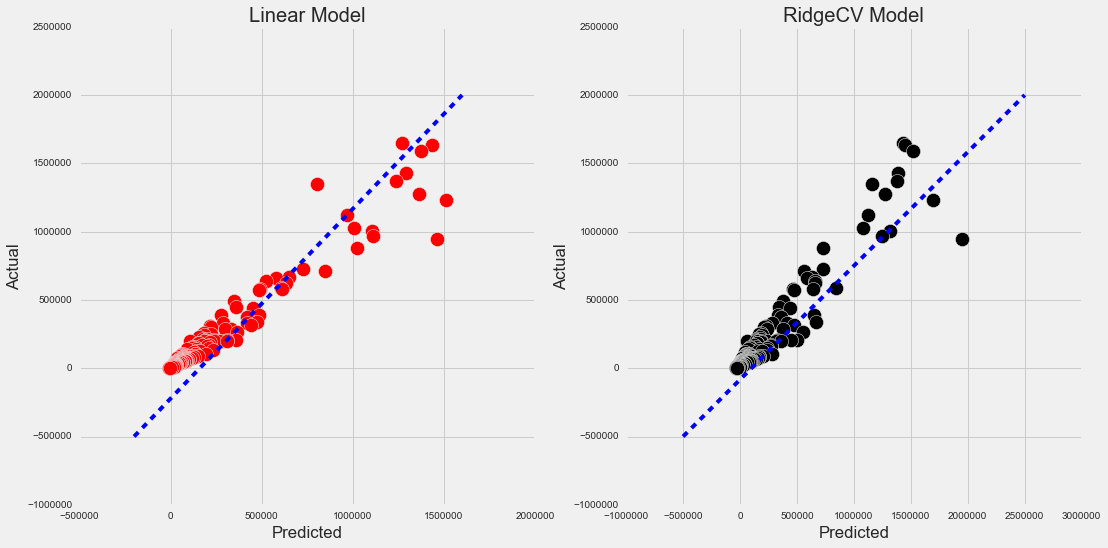

In [222]:
fig, axes = plt.subplots(1,2, figsize=(16,8))

axes[0].scatter(pred, dfp_piv['Sale (Dollars)'], c='red', s = 200)
axes[0].plot(axes[0].get_xlim(), axes[0].get_ylim(), ls="--", c='b')

axes[1].scatter(pred_rcv, dfp_piv['Sale (Dollars)'], c='k', s = 200)
axes[1].plot(axes[1].get_xlim(), axes[1].get_ylim(), ls="--", c='b')


axes[0].set_title('Linear Model')
axes[0].set_ylabel('Actual')
axes[0].set_xlabel('Predicted')

axes[1].set_title('RidgeCV Model')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted');

# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.